In [1]:
import math
from typing import Tuple, Optional, List, Iterator
from pathlib import Path
from IPython.display import clear_output

import torchvision
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torch import nn

import matplotlib.pyplot as plt

from tqdm import tqdm

from PIL import Image

In [2]:
# Weight normalizer that help the optimizer with very large and small weight 
class EqualizedWeight(nn.Module):
    def __init__(self, shape : List[int]):
        super().__init__()
        self.c = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))

    def forward(self):
        return self.weight * self.c

In [3]:
# Linear module with equalized weight
class EqualizedLinear(nn.Module):
    
    def __init__(self, in_features : int, out_features : int, bias : float = 0.):
        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)
    
    def forward(self, x : torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)

In [4]:
# Conv2d module with equalized weight
class EqualizedConv2d(nn.Module):
    
    def __init__(self, in_features : int, out_features : int, kernel_size : int, padding : int = 0):
        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))
    
    def forward(self, x : torch.Tensor):
        return F.conv2d(x, self.weight(), bias = self.bias, padding = self.padding)

In [5]:
# Blur the image module (help to clear patches and irregularities)
class Smooth(nn.Module):

    def __init__(self):
        super().__init__()

        # Blur kernel
        kernel = [
            [1, 2, 1],
            [2, 4, 2],
            [1, 2, 1]
        ]

        kernel = torch.tensor([[kernel]], dtype = torch.float)
        # normalize the kernel
        kernel /= kernel.sum()

        # this layer isn't trained
        self.kernel = nn.Parameter(kernel, requires_grad=False)
        # used to smooth the edge by clonning each edge by 1
        self.pad = nn.ReplicationPad2d(1)

    def forward(self, x : torch.Tensor):
        batch, chan, height, width = x.shape

        # Unfolding the channels has batch * chan images for the conv2d operation
        # Because we dont want the images to blur between the channels
        x = x.view(-1, 1, height, width)
        x = self.pad(x)
        x = F.conv2d(x, self.kernel)

        return x.view(batch, chan, height, width)

In [6]:
# Smooth each feature channels and scale down by 2 using bilinear interpolation
class DownSample(nn.Module):
    
    def __init__(self, use_smooth=True):
        super().__init__()

        self.use_smooth = use_smooth
        if use_smooth:
            self.smooth = Smooth()
    
    def forward(self, x : torch.Tensor):
        if self.use_smooth:
            x = self.smooth(x)
        return F.interpolate(x, (x.shape[2] // 2, x.shape[3] // 2), mode="bilinear", align_corners=False)

In [7]:
# Smooth each feature channels and scale up by 2 using bilinear torch upsampling layer
class UpSample(nn.Module):

    def __init__(self, use_smooth=True):
        super().__init__()

        self.use_smooth = use_smooth
        if use_smooth:
            self.smooth = Smooth()
        
        self.up_sample = nn.Upsample(scale_factor = 2, mode="bilinear", align_corners=False)
    
    def forward(self, x : torch.Tensor):
        x = self.up_sample(x)

        if self.use_smooth:
            x = self.smooth(x)
        
        return x

In [8]:
# Mini-batch Standard Deviation
class MiniBatchStdDev(nn.Module):
    """
    Mini-batch standard deviation calculates the standard deviation
    across a mini-batch (or a subgroups within the mini-batch)
    for each feature in the feature map. Then it takes the mean of all
    the standard deviations and appends it to the feature map as one extra feature.
    It also helps with the model collapse problem
    """

    def __init__(self, group_size=4, num_new_features=1):
        super().__init__()
        self.group_size = group_size
        self.num_new_features = num_new_features    

    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        g = torch.min(torch.as_tensor(self.group_size), torch.as_tensor(b)) if self.group_size is not None else b
        f = self.num_new_features
        c = c // f

        # Split minibatch N into n groups of size G, and channels C into F groups of size c.
        y = x.reshape(g, -1, f, c, h, w)
        # Subtract mean over group.
        y = y - y.mean(dim=0)
        # Calculate variance over group.
        y = y.square().mean(dim=0)
        # Calculate stddev over group.
        y = (y + 1e-8).sqrt()
        # Take average over channels and pixels.
        y = y.mean(dim=[2,3,4])
        # Add missing dimensions.
        y = y.reshape(-1, f, 1, 1)
        # Replicate over group and pixels.
        y = y.repeat(g, 1, h, w)
        # Append to input as new channels.
        x = torch.cat([x, y], dim=1)
        return x

<img src="mapping_network.svg">

First the mapping network

In [9]:
# map the latent vector to an intermediate latent space
class MappingNetwork(nn.Module):

    def __init__(self, features : int, n_layers : int):
        super().__init__()
        layers = []
        for i in range(n_layers):
            layers.append(EqualizedLinear(features, features))
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z : torch.Tensor):
        z = F.normalize(z, dim = 1)
        return self.net(z)

In [10]:
# weigh modulation and demodulation operation (scale by the style vector and demodulate by normalize the result)
class Conv2dWeightModulate(nn.Module):

    def __init__(self, in_features: int, out_features : int, kernel_size : int, demodulate : bool = True, eps : float = 1e-8):
        super().__init__()

        self.out_features = out_features
        self.demodulate = demodulate
        self.padding = (kernel_size - 1) // 2
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.eps = eps

    def forward(self, x : torch.Tensor, s : torch.Tensor):
        '''
        x of shape [batch_size, in_features, out_features, height, width]
        s of shape [batch_size, in_features]
        '''
        b, _, h, w = x.shape
        # reshaping the style tensor
        s = s[:, None, :, None, None]
        weights = self.weight()[None, :, :, :, :]

        # weight modulation by style tensor
        weights = weights * s

        # demodulation
        if self.demodulate:
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * sigma_inv

        # reshape input tensor for faster computation
        x = x.reshape(1, -1, h, w)

        # reshape weights for convolution
        _, _, *weight_shapes = weights.shape
        weights = weights.reshape(b * self.out_features, *weight_shapes)

        # grouped convolution computation (repeat same convolution groups time along first axis)
        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        # reshape to [batch_size, out_features, height, width]
        return x.reshape(-1, self.out_features, h, w)

<img src="style_block.svg">

Then the style block

In [11]:
# The most basic building block of the generator
class StyleBlock(nn.Module):

    def __init__(self, d_latent : int, in_features : int, out_features : int):
        '''
        d_latent : the dimension of the input vector from the latent space
        in_features : the number of features in the input feature map
        out_features : the number of features in the output feature map
        '''

        super().__init__()
        
        # get style vector from latent space vector
        self.to_style = EqualizedLinear(d_latent, in_features, bias=1.0)
        
        # compute modulated and demodulated convolution
        self.conv = Conv2dWeightModulate(in_features, out_features, kernel_size=3)

        self.scale_noise = nn.Parameter(torch.zeros(1))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x : torch.Tensor, w : torch.Tensor, noise : Optional[torch.Tensor]):
        # get style vector
        s = self.to_style(w)
        
        # compute convolution operation
        x = self.conv(x, s)

        if noise is not None:
            x += self.scale_noise[None, :, None, None] * noise
        return self.activation(x + self.bias[None, :, None, None])

<img src="to_rgb.svg">

ToRGB layer for the generator

In [12]:
class ToRGB(nn.Module):
    
    def __init__(self, d_latent : int, features : int):
        super().__init__()

        # get style vector from latent space vector
        self.to_style = EqualizedLinear(d_latent, features, bias=1.0)

        # compute modulated convolution
        self.conv = Conv2dWeightModulate(features, 3, kernel_size=1, demodulate=False)

        self.bias = nn.Parameter(torch.zeros(3))
        self.activation = nn.LeakyReLU(0.2, True)
    
    def forward(self, x : torch.Tensor, w : torch.Tensor):
        s = self.to_style(w)
        x = self.conv(x, s)

        return self.activation(x + self.bias[None, :, None, None])

<img src="generator_block.svg">

Putting it all together here is the generator block

In [13]:
# Generator network that generate an image from a latent vector
class GeneratorBlock(nn.Module):

    def __init__(self, d_latent : int, in_features : int, out_features : int):
        super().__init__()

        self.style_block1 = StyleBlock(d_latent, in_features, out_features)
        self.style_block2 = StyleBlock(d_latent, out_features, out_features)

        self.to_rgb = ToRGB(d_latent, out_features)
    
    def forward(self, x : torch.Tensor, w : torch.Tensor, noise: Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]):

        x = self.style_block1(x, w, noise[0])
        x = self.style_block2(x, w, noise[1])

        rgb = self.to_rgb(x, w)

        return x, rgb

<img src="style_gan2.svg">

And finaly the mighty generator

In [14]:
class Generator(nn.Module):

    def __init__(self, log_resolution : int, d_latent : int, n_features : int = 32, max_features : int = 512):
        '''
        log_resolution : is the log2 of image resolution (used to calculate features)
        d_latent : the dimensionality of the latent vector
        n_features : number of features in the final convolution layer
        max_features : maximum number of features in any generator block
        '''
        super().__init__()

        # Calculate the number of features for each block
        # looks like [512, 512, 256, 128, 64, 32]
        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 2, -1, -1)]

        self.n_blocks = len(features)

        # trainable constant 
        self.initial_constant = nn.Parameter(torch.randn((1, features[0], 4, 4)))

        # Initial style block
        self.style_block = StyleBlock(d_latent, features[0], features[0])
        self.to_rgb = ToRGB(d_latent, features[0])

        # generator blocks
        blocks = [GeneratorBlock(d_latent, features[i - 1], features[i]) for i in range(1, self.n_blocks)]
        self.blocks = nn.ModuleList(blocks)

        # upsampling at each block
        self.up_sample = UpSample()

    def forward(self, w : torch.Tensor, input_noise : List[Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]]):
        '''
        w : In order to mix-styles (use different w for different layers), we provide a separate w for each generator block. It has shape [n_blocks, batch_size, d_latent]
        input_noise : tuple of noise for each block
        '''

        batch_size = w.shape[1]

        x = self.initial_constant.expand(batch_size, -1, -1, -1)
        x = self.style_block(x, w[0], input_noise[0][1])
        rgb = self.to_rgb(x, w[0])

        for i in range(1, self.n_blocks):
            x = self.up_sample(x)

            x, rgb_new = self.blocks[i - 1](x, w[i], input_noise[i])
            
            rgb = self.up_sample(rgb) + rgb_new

        return rgb

<img src="discriminator_block.svg">

The discriminator block

In [15]:
class DiscrimanatorBlock(nn.Module):

    def __init__(self, in_features : int, out_features : int):
        super().__init__()

        # The skip connection line
        self.residual = nn.Sequential(
            DownSample(), 
            EqualizedConv2d(in_features, out_features, kernel_size=1)
        )

        # The main line
        self.block = nn.Sequential(
            EqualizedConv2d(in_features, in_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
            EqualizedConv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True)
       )

        self.downsample = DownSample()

        # Scaling after the residual adding operation
        self.scale = 1 / math.sqrt(2)


    def forward(self, x : torch.Tensor):
        res = self.residual(x)
        x = self.block(x)
        x = self.downsample(x)
        
        return (x + res) * self.scale

<img src="style_gan2_disc.svg">

And the last one, The discriminator

In [16]:
class Discriminator(nn.Module):

    def __init__(self, log_resolution : int, n_features : int = 64, max_features : int = 512):
        super().__init__()

        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )


        # Calculate the number of features for each block.
        # Something like [64, 128, 256, 512, 512, 512]        
        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]

        n_blocks = len(features) - 1

        # Discriminator blocks
        blocks = [DiscrimanatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        # Adding variation to the data with minibatch standard deviation
        self.std_dev = MiniBatchStdDev()

        final_features = features[-1] + 1

        # Last conv layer
        self.conv = EqualizedConv2d(final_features, final_features, 3)

        # final linear classification
        self.classify = EqualizedLinear(2 * 2 * final_features, 1)

    def forward(self, x : torch.Tensor):
        x = x - 0.5
        x = self.from_rgb(x)

        x = self.blocks(x)
        x = self.std_dev(x)
        x = self.conv(x)

        x = x.reshape(x.shape[0], -1)
        return self.classify(x)

This is the r1 regularization from the paper [Which Training Methods for GANs do actually Converge?](https://arxiv.org/abs/1801.04406).

$ R_1 (\psi) = \frac{\gamma}{2} \mathbb{E}_{P_{D(x)}} \left [  \left \| \nabla_x D_{\psi}(x)^2 \right \|\right ] $

it penalyze the discriminator for deviation from the [nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium) by reducing the convergence speed.

In [17]:
class GradientPenalty(nn.Module):
    def forward(self, x : torch.Tensor, d : torch.Tensor):
        gradients, *_ = torch.autograd.grad(outputs=d,
                                            inputs=x,
                                            grad_outputs=d.new_ones(d.shape),
                                            retain_graph=True)

        gradients = gradients.reshape(x.shape[0], -1)
        norm = gradients.norm(2, dim=-1)

        return torch.mean(norm ** 2) * (self.gamma / 2)

This regularization encourages a fixed-size step in w to result in a fixed-magnitude change in the image.

we use this formula for regularization :

$ E_{w∼f(z),y∼N(0,I)}(||J^⊤_wy||_2−a)^2 $

to compute the jacobian, we will use :

$ J_w^Ty = \nabla_w(g(w) * y) $


a is the exponential moving average of $ ||J^⊤_wy||^2 $ as the training progresses:

$ a = \frac{1}{1 - \beta^N} \sum_{i=1}^{N} \beta^{(N - i)}[J_w^Ty]_i$

In [18]:
class PathLengthPenalty(nn.Module):
    def __init__(self, beta: float):
        super().__init__()
        self.beta = beta

        # Number of steps N
        self.steps = nn.Parameter(torch.tensor(0.), requires_grad=False)
        # Exponential sum of the jacobian time y
        self.exp_sum_a = nn.Parameter(torch.tensor(0.), requires_grad=False)

    def forward(self, w : torch.Tensor, x : torch.Tensor):
        '''
        w : the batch of w of shape [batch_size, d_latent]
        x : the generated images of shape [batch_size, 3, height, width]
        '''

        device = x.device
        image_size = x.shape[2] * x.shape[3]

        # Calculate y ∈ N(0,I)
        y = torch.randn(x.shape, device=device)

        # Calculate (g(w)⋅y) and normalize by the square root of image size. 
        # We can find it in their implementation.
        output = (x * y).sum() / math.sqrt(image_size)

        gradients, *_ = torch.autograd.grad(output=output,
                                            inputs=w,
                                            grad_outputs=torch.ones(output.shape, device=device),
                                            create_graph=True)

        norm = (gradients ** 2).sum(dim=2).mean(dim=1).sqrt()

        if self.steps > 0:
            # let's calculate a with the exponential sum of moving average
            a = self.exp_sum_a / (1 - self.beta ** self.steps)
            # and finaly the penalty
            loss = torch.mean((norm - a) ** 2)
        else:
            # do not penalyze the first step because we can't have a moving average
            loss = norm.new_tensor(0)
        
        mean = norm.mean().detach()
        self.exp_sum_a.mul_(self.beta).add_(mean, alpha=1 - self.beta)
        self.steps.add_(1.)
        
        return loss

In [19]:
class Dataset(data.Dataset):
    def __init__(self, path: str, image_size: int):
        super().__init__()
        self.paths = [p for p in Path(path).glob(f'**\\*.jpg')] + [p for p in Path(path).glob(f'**\\*.png')]
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.RandomCrop(image_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ColorJitter(.15,.2,.2),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ])
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path).convert("RGB")
        return self.transform(img)

In [20]:
# _dataset = Dataset("E:\\projects\\StyleGan2Pytorch\\dataset", 1024)

# for i in range(10):
#     batch = torchvision.transforms.ToPILImage()(_dataset[14242])
#     plt.imshow(batch)
#     plt.show()

 We want to find $w$ to maximize
$ \mathbb{E}_{x \sim \mathbb{P}_r} [f_w(x)]- \mathbb{E}_{z \sim p(z)} [f_w(g_\theta(z))] $,
so we minimize,
$ -\frac{1}{m} \sum_{i=1}^m f_w \big(x^{(i)} \big) + \frac{1}{m} \sum_{i=1}^m f_w \big( g_\theta(z^{(i)}) \big) $

In [21]:
class DiscriminatorLoss(nn.Module):
    """
    A big score will represent a real image. So we want the fake_score to be small and the real_score
    to be high. So we penalyze the discriminator the other way around. We use softplus because it helps
    the the discriminator learn even if the score is a small negative. 
    """
    def __call__(self, real_score : torch.Tensor, fake_score : torch.Tensor):
        return F.softplus(-real_score).mean(), F.softplus(fake_score).mean()

 We want to find $\theta$ to minimize
    $$\mathbb{E}_{x \sim \mathbb{P}_r} [f_w(x)]- \mathbb{E}_{z \sim p(z)} [f_w(g_\theta(z))]$$
    The first component is independent of $\theta$,
    so we minimize,
    $$-\frac{1}{m} \sum_{i=1}^m f_w \big( g_\theta(z^{(i)}) \big)$$

In [22]:
class GeneratorLoss(nn.Module):
    """
    The more the fake_score is big, the more the discriminator believe that the fake image is real
    so we penalyze the generator when the discriminator return a small fake_score.  
    """
    def __call__(self, fake_score: torch.Tensor):
        return F.softplus(-fake_score).mean()

In [23]:
def infinite_loader(dataloader):
    while True:
        for batch in dataloader:
            yield batch

In [24]:
def accumulate(model1, model2, decay=0.999):
    assert decay < 1, "decay must be smaller than one"
    params1 = dict(model1.named_parameters())
    params2 = dict(model2.named_parameters())
    
    for k in params1.keys():
        params1[k].data.mul_(decay).add_(params2[k].data, alpha=1 - decay)

In [25]:
import json

class DevEnvironment():

    def __init__(self, config_file):
        '''
        config_file: path to the config file
        '''
        config = json.loads(open(config_file).read())
        self.optimizer = config["optimizer"] if "optimizer" in config else "Adam"

        self.use_gradient_penalty = config["use_gradient_penalty"] if "use_gradient_penalty" in config else True
        self.gradient_penalty_coefficient = config["gradient_penalty_coefficient"] if "gradient_penalty_coefficient" in config else 10
        self.lazy_gradient_penalty_interval = config["lazy_gradient_penalty_interval"] if "lazy_gradient_penalty_interval" in config else 4
        self.use_path_length_penalty = config["use_path_length_penalty"] if "use_path_length_penalty" in config else True
        self.lazy_path_penalty_interval = config["lazy_path_penalty_interval"] if "lazy_path_penalty_interval" in config else 32
        self.lazy_path_penalty_after = config["lazy_path_penalty_after"] if "lazy_path_penalty_after" in config else 5000
        self.batch_size = config["batch_size"] if "batch_size" in config else 16
        self.d_latent = config["d_latent"] if "d_latent" in config else 512
        self.max_features = config["max_features"] if "max_features" in config else 1024
        self.image_size = config["image_size"] if "image_size" in config else 1024
        
        self.mapping_network_layers = config["mapping_network_layers"] if "mapping_network_layers" in config else 8
        
        self.learning_rate_discr = config["learning_rate_discr"] if "learning_rate_discr" in config else 4e-4
        self.learning_rate_gen = config["learning_rate_gen"] if "learning_rate_gen" in config else 1e-4
        self.mapping_network_learning_rate = config["mapping_network_learning_rate"] if "mapping_network_learning_rate" in config else 1e-5
        
        self.gradient_accumulate_steps = config["gradient_accumulate_steps"] if "gradient_accumulate_steps" in config else 1
        self.style_mixing_prob = config["style_mixing_prob"] if "style_mixing_prob" in config else 0.9
        self.training_steps = config["training_steps"] if "training_steps" in config else 500_000
        
        self.save_checkpoint_interval = config["save_checkpoint_interval"] if "save_checkpoint_interval" in config else 2000
        self.log_generated_interval = config["log_generated_interval"] if "log_generated_interval" in config else 500
        
        self.reset_EMA = config["reset_EMA"] if "reset_EMA" in config else 5000
        self.accumulate = config["accumulate"] if "accumulate" in config else 0.997
        
        self.dataset_path = config["dataset_path"] if "dataset_path" in config else "E:\\projects\\StyleGan2Pytorch\\gallery-dl\\flickr\\Groups\\Landscape"
        
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.log_resolution = int(np.log2(self.image_size))

        self.mapping_network = MappingNetwork(self.d_latent, self.mapping_network_layers).to(self.device)
        self.discriminator = Discriminator(self.log_resolution).to(self.device)
        self.generator = Generator(self.log_resolution, self.d_latent).to(self.device)
        self.generator_ema = Generator(self.log_resolution, self.d_latent).to(self.device)

        self.generator_ema.eval()

        accumulate(self.generator_ema, self.generator, 0)

        self.n_gen_blocks = self.generator.n_blocks
        
        dataset = Dataset(self.dataset_path, self.image_size)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.loader = infinite_loader(dataloader)

        self.path_length_penalty = PathLengthPenalty(0.99).to(self.device)
        self.gradient_penalty = GradientPenalty()

        self.discriminator_loss = DiscriminatorLoss().to(self.device)
        self.generator_loss = GeneratorLoss().to(self.device)

        self.adam_betas = (0.0, 0.99)

        self.discriminator_optimizer = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.learning_rate_discr, betas=self.adam_betas
        )
        self.generator_optimizer = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.learning_rate_gen, betas=self.adam_betas
        )
        self.mapping_network_optimizer = torch.optim.Adam(
            self.mapping_network.parameters(),
            lr=self.mapping_network_learning_rate, betas=self.adam_betas
        )
    
    ''' to load
    "mnet", "g", "d", "mnet_optim", "g_optim", "d_optim"
    '''
    def laod_save(self, file_path : str):
        saved = torch.load(file_path, map_location=lambda storage, loc: storage)

        self.generator.load_state_dict(saved["g"], strict=False)
        self.mapping_network.load_state_dict(saved["mnet"], strict=False)
        self.discriminator.load_state_dict(saved["d"], strict=False)
        self.mapping_network_optimizer.load_state_dict(saved["mnet_optim"])
        self.generator_optimizer.load_state_dict(saved["g_optim"])
        self.discriminator_optimizer.load_state_dict(saved["d_optim"])
        accumulate(self.generator_ema, self.generator, 0)

In [26]:
env = DevEnvironment("config.json")

sample a random vector $ z $ and get $ w $ from the mapping network. Also do style mixing with probability style_mixing_prob

In [27]:
def sample_w(env : DevEnvironment):
    if np.random.rand() < env.style_mixing_prob:
        cross_over_point = int(np.random.rand() * env.n_gen_blocks)

        z1 = torch.randn(env.batch_size, env.d_latent).to(env.device)
        z2 = torch.randn(env.batch_size, env.d_latent).to(env.device)

        w1 = env.mapping_network(z1)[None, :, :].expand(cross_over_point, -1, -1)
        w2 = env.mapping_network(z2)[None, :, :].expand(env.n_gen_blocks - cross_over_point, -1, -1)

        return torch.cat((w1, w2), dim=0)

    else:
        z = torch.randn(env.batch_size, env.d_latent).to(env.device)

        w = env.mapping_network(z)
    
        return w[None, :, :].expand(env.n_gen_blocks, -1, -1)

In [28]:
def sample_noise(env : DevEnvironment):
    noise = []
    resolution = 4
    for i in range(env.n_gen_blocks):
        # First layer only have one style block
        if i == 0:
            n1 = None
        else:
            n1 = torch.randn(env.batch_size, 1, resolution, resolution, device=env.device)
        n2 = torch.randn(env.batch_size, 1, resolution, resolution, device=env.device)
        resolution *= 2
        noise.append((n1, n2))
    return noise;

In [29]:
def generate_images(env: DevEnvironment):
    w = sample_w(env)

    noise = sample_noise(env)

    images = env.generator(w, noise)
    return images, w

In [30]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [31]:
import gc
def clean():
    torch.cuda.empty_cache()
    gc.collect()

In [32]:
def step(index : int, env: DevEnvironment):
    with torch.cuda.amp.autocast():
        real_img = next(env.loader).to(env.device)
    requires_grad(env.generator, False)
    requires_grad(env.mapping_network, False)
    requires_grad(env.discriminator, True)
    
    with torch.cuda.amp.autocast():
        fake_img, _ = generate_images(env)
        fake_pred = env.discriminator(fake_img)

        real_pred = env.discriminator(real_img)
        real_loss, fake_loss = env.discriminator_loss(real_pred, fake_pred)
        
        d_loss = real_loss + fake_loss
    
    env.discriminator.zero_grad()
    d_loss.backward()

    torch.nn.utils.clip_grad_norm_(env.discriminator.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_value_(env.discriminator.parameters(), 1.0)
    for params in env.discriminator.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)

    env.discriminator_optimizer.step()

    if (index + 1) % env.lazy_gradient_penalty_interval == 0:
        with torch.cuda.amp.autocast():
            real_img.requires_grad_()
            real_pred = env.discriminator(real_img)
            gp = env.gradient_penalty(real_img, real_pred) * env.gradient_penalty_coefficient
        env.discriminator.zero_grad()
        gp.backward()

        torch.nn.utils.clip_grad_norm_(env.discriminator.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_value_(env.discriminator.parameters(), 1.0)
        for params in env.discriminator.parameters():
            torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)
        env.discriminator_optimizer.step()

    requires_grad(env.generator, True)
    requires_grad(env.mapping_network, True)
    requires_grad(env.discriminator, False)

    with torch.cuda.amp.autocast():
        fake_img, _ = generate_images(env)
        fake_pred = env.discriminator(fake_img)
        
        g_loss = env.generator_loss(fake_pred)

    env.generator.zero_grad()
    env.mapping_network.zero_grad()
    g_loss.backward()

    torch.nn.utils.clip_grad_norm_(env.generator.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_value_(env.generator.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(env.mapping_network.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_value_(env.mapping_network.parameters(), 1.0)
    for params in env.generator.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)
    for params in env.mapping_network.parameters():
        torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)

    env.generator_optimizer.step()
    env.mapping_network_optimizer.step()

    if index > env.lazy_path_penalty_after and (index + 1) % env.lazy_path_penalty_interval == 0:      
        with torch.cuda.amp.autocast():
            fake_img, w = generate_images(env)
            
            plp = env.path_length_penalty(w, fake_img)
            plp = 2 * env.lazy_path_penalty_interval * plp
        
        env.generator.zero_grad()
        plp.backward()

        torch.nn.utils.clip_grad_norm_(env.generator.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_value_(env.generator.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(env.mapping_network.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_value_(env.mapping_network.parameters(), 1.0)
        for params in env.generator.parameters():
            torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)
        for params in env.mapping_network.parameters():
            torch.nan_to_num_(params.grad, nan=0, posinf=1e5, neginf=-1e5)

        env.generator_optimizer.step()

    if not (index + 1) % env.reset_EMA:
        accumulate(env.generator_ema, env.generator, 0)
    else:
        accumulate(env.generator_ema, env.generator, env.accumulate)

    return d_loss.detach(), g_loss.detach()

In [33]:
# record all the losses to find eventual bugs
loss_record = {"gen": [], "discr": []}

In [34]:
def plot_losses(loss_record):
    clear_output(wait=True)
    plt.plot(range(len(loss_record["gen"])), loss_record["gen"], 'g', label='generator loss')
    plt.plot(range(len(loss_record["discr"])), loss_record["discr"], 'b', label='discriminator loss')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

We'll do the next cell just one time and then we will just load this from a file

In [35]:
# generate the latents used for sampling

N_SAMP = 16
'''
example_z = torch.randn(N_SAMP, env.d_latent).to(env.device)
example_w = env.mapping_network(example_z).detach()
example_w = example_w[None, :, :].expand(env.n_gen_blocks, -1, -1)
example_noise = []
resolution = 4
for i in range(env.n_gen_blocks):
    # First layer only have one style block
    if i == 0:
        n1 = None
    else:
        n1 = torch.randn(N_SAMP, 1, resolution, resolution, device=env.device)
    n2 = torch.randn(N_SAMP, 1, resolution, resolution, device=env.device)
    resolution *= 2
    example_noise.append((n1, n2))
del example_z
torch.save({"sample_w": example_w, "sample_noise": example_noise}, "sample_tensors.pt")
del example_w
del example_noise
clean()
'''

'\nexample_z = torch.randn(N_SAMP, env.d_latent).to(env.device)\nexample_w = env.mapping_network(example_z).detach()\nexample_w = example_w[None, :, :].expand(env.n_gen_blocks, -1, -1)\nexample_noise = []\nresolution = 4\nfor i in range(env.n_gen_blocks):\n    # First layer only have one style block\n    if i == 0:\n        n1 = None\n    else:\n        n1 = torch.randn(N_SAMP, 1, resolution, resolution, device=env.device)\n    n2 = torch.randn(N_SAMP, 1, resolution, resolution, device=env.device)\n    resolution *= 2\n    example_noise.append((n1, n2))\ndel example_z\ntorch.save({"sample_w": example_w, "sample_noise": example_noise}, "sample_tensors.pt")\ndel example_w\ndel example_noise\nclean()\n'

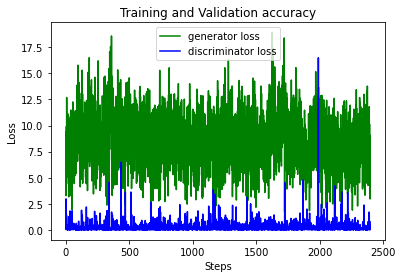

disc_loss: 0.12104485929012299, gen_loss: 9.014169692993164:   1%|          | 2416/474600 [1:44:07<709:09:09,  5.41s/it]

In [36]:
#Load the sample tensors
saved = torch.load( "sample_tensors.pt", map_location=lambda storage, loc: storage)
sampled_w = saved["sample_w"].to(env.device)
sampled_noise = [(a.to(env.device), b.to(env.device)) if i != 0 else (a, b.to(env.device)) for i, (a, b) in enumerate(saved["sample_noise"])]

#Hard coded
start_iteration=27800

pbar = tqdm(range(start_iteration, env.training_steps))

if (start_iteration != 0):
    env.laod_save(f"checkpoint/{str(start_iteration).zfill(6)}.pt")

for i in pbar:
    clean()
    if not ((i + 1) % env.log_generated_interval):
        with torch.no_grad():
            env.generator_ema.eval()
            images = env.generator_ema(sampled_w, sampled_noise)
            torchvision.utils.save_image(
                images,
                f"sample/{str(i+1).zfill(6)}.png",
                nrow=int(4),
                normalize=True,
                value_range=(-1, 1),
            )
            del images
        clean()
        plot_losses(loss_record)
    if not ((i + 1) % env.save_checkpoint_interval):
        torch.save(
            {
                "mnet": env.mapping_network.state_dict(),
                "g": env.generator.state_dict(),
                "d": env.discriminator.state_dict(),
                "mnet_optim": env.mapping_network_optimizer.state_dict(),
                "g_optim": env.generator_optimizer.state_dict(),
                "d_optim": env.discriminator_optimizer.state_dict(),
            },
            f"checkpoint/{str(i+1).zfill(6)}.pt",
        )
    discriminator_loss, generator_loss = step(0, env)
    if pbar.n == env.training_steps:
        break
    loss_record["gen"].append(generator_loss.cpu())
    loss_record["discr"].append(discriminator_loss.cpu())
    pbar.set_description("disc_loss: {}, gen_loss: {}".format(discriminator_loss, generator_loss))

In [1]:
plot_losses(loss_record)

NameError: name 'plot_losses' is not defined